<hr>
<h1 align="center">Redes neuronales de Grafos Espacio Temporales</h1>
<hr>

El objetivo de este cuaderno es desarrollar una Red Neuronal de Grafos Espaciotemporal (STGNN) para la predicción de tráfico utilizando <img src="https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/main/docs/source/_static/img/tsl_logo.svg" width="30px" align="center"/> [**Torch Spatiotemporal (tsl)**](https://torch-spatiotemporal.readthedocs.io/), una librería de Python diseñada específicamente para el procesamiento neuronal de datos espaciotemporales.

Torch Spatiotemporal se basa en librerías populares del ecosistema científico de Python, como PyTorch, PyTorch Geometric (PyG) y PyTorch Lightning. Simplifica el flujo de trabajo para tareas que involucran series de tiempo con información relacional, incluyendo el preprocesamiento, el desarrollo de modelos y la evaluación.

<hr>

# **Inicio**

<hr>

## Instalacion
<hr>

Lo primero que debemos realizar es configurar nuestro entorno de python que debe ser python >= 3.10

Agregaremos las librerias necesarias

In [1]:
# Install initial dependencies
%pip install -U pandas==2.0
%pip install -U torch==2.3
%pip install -U matplotlib
%pip install -U tensorboard

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Se debe tener en cuenta que tsl debe instalarse en un entorno de Python que ya contenga Pytorch y PyG.

Para eso instalamos las dependencias.

Finalizamos instalando tsl desde GitHub, para estar al día con la última versión.

Ademas descargamos un utility que necesitaremos.


In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Install PyG dependencies
%pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html -f https://data.pyg.org/whl/torch-${TORCH}+cpu.html
%pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Install tsl from source
%pip install -q git+https://github.com/TorchSpatiotemporal/tsl.git
!wget -q --show-progress -O notebook_utils.py https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/refs/heads/dev/examples/notebooks/_notebook_utils.py

2.3.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
notebook_utils.py   100%[===================>]   7.96K  --.-KB/s    in 0s      


Nos remitimos a las guías de instalación de [tsl](https://torch-spatiotemporal.readthedocs.io/en/latest/usage/quickstart.html) y [PyG](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) para la configuración en otros entornos.

## Verificacion
<hr>
<h2 style="color: red">IMPORTANTE: Se debe reiniciar el kernel para aplicar los cambios de las librerias</h2>

Comprobemos si todo está bien.

In [3]:
import tsl
import torch
import torch_geometric

print(f"torch version: {torch.__version__}")
print(f"  PyG version: {torch_geometric.__version__}")
print(f"  tsl version: {tsl.__version__}")

/opt/anaconda3/envs/spatio_temporal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch version: 2.3.0
  PyG version: 2.7.0
  tsl version: 0.9.6


<hr>

# **Cargar y Preprocesar Data**

<hr>

## Cargar un dataset tabular
<hr>

<img src="https://raw.githubusercontent.com/TorchSpatiotemporal/tsl/main/docs/source/_static/img/tsl_logo.svg" width="25px" align="center"/> tsl incluye una variedad de conjuntos de datos populares en la bibliografía. Puedes encontrarlos en el submódulo [`tsl.datasets`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets.html).

In [ ]:
from tsl import datasets

# List available datasets
print("Datasets in tsl:", *datasets.dataset_classes, sep='\n- ')

Datasets in tsl:
- AirQuality
- Elergone
- EngRad
- MetrLA
- PemsBay
- PeMS03
- PeMS04
- PeMS07
- PeMS08
- LargeST
- PvUS
- ElectricityBenchmark
- TrafficBenchmark
- SolarBenchmark
- ExchangeBenchmark
- GaussianNoiseSyntheticDataset
- GPVARDataset
- GPVARDatasetAZ


Para este ejercicio usaremos el conjunto de datos [MetrLA](https://paperswithcode.com/sota/traffic-prediction-on-metr-la), un punto de referencia (benchmark) ampliamente utilizado para la predicción del tráfico. Este conjunto de datos consiste en lecturas de la velocidad del tráfico de 207 sensores en las autopistas del condado de Los Ángeles, agregadas en intervalos de 5 minutos durante un periodo de 4 meses (de marzo a junio de 2012).

Cargar el conjunto de datos es así de simple:

In [ ]:
from tsl.datasets import MetrLA

dataset = MetrLA(root='./data')
# Show dataset information
print(dataset)

MetrLA(length=34272, n_nodes=207, n_channels=1)


Todos los conjuntos de datos en tsl son subclases de la clase raíz [`tsl.datasets.Dataset`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets_prototypes.html#tsl.datasets.prototypes.Dataset), las cuales exponen APIs útiles para conjuntos de datos espacio-temporales. Podemos ver que los datos están organizados en un array tridimensional, con:

* **34.272** pasos de tiempo (1 cada 5 minutos durante 4 meses)
* **207** nodos (los detectores o sensores)
* **1** canal (la velocidad detectada)

¡Genial! Además de almacenar los datos de interés, el conjunto de datos viene con herramientas útiles.

In [6]:
print(f"Sampling period: {dataset.freq}")
print(f"Has missing values: {dataset.has_mask}")
print(f"Percentage of missing values: {(1 - dataset.mask.mean()) * 100:.2f}%")
print(f"Has exogenous variables: {dataset.has_covariates}")
print(f"Covariates: {', '.join(dataset.covariates.keys())}")

Sampling period: <5 * Minutes>
Has missing values: True
Percentage of missing values: 8.11%
Has exogenous variables: True
Covariates: dist


Sampling period: <5 * minutes> 
- Esto confirma la frecuencia de los datos. Tienes una nueva medición cada 5 minutos.

Has missing values: True y Percentage of missing values: 8.11%
- Esto es súper importante. Los datos del mundo real casi nunca son perfectos. Aquí se confirma que faltan algunos datos (un sensor pudo fallar, hubo un error de transmisión, etc.).
- El dataset tiene una "máscara" (dataset.mask) que te dirá exactamente qué valores faltan para que puedas manejarlos correctamente más adelante.

Has exogenous variables: True y Covariates: 'dist'
- Variables exógenas (o covariables) son datos adicionales que no son lo que quieres predecir (la velocidad), pero que pueden ayudar al modelo a predecir mejor.
- Aquí, te dice que tienes una covariable llamada 'dist'. Esta es casi con seguridad una matriz de distancia. Es una tabla que le dice al modelo qué tan lejos está cada sensor de todos los demás sensores. Esta información es CRUCIAL para que el modelo entienda la estructura espacial de la red de carreteras.

Veamos la salida. Sabemos que el conjunto de datos tiene entradas faltantes, siendo `dataset.mask` un indicador binario asociado con cada paso de tiempo, nodo y canal (donde los unos indican valores válidos).

Además, el conjunto de datos tiene un atributo de **covariable** (es decir, variables exógenas) – la matriz de distancias – que contiene las distancias por pares entre los sensores.

Puedes acceder a las covariables mediante `dataset.{nombre_covariable}`:

In [7]:
from notebook_utils import *
print_matrix(dataset.dist)

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,0.00,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,3764.70,inf,inf,9204.30,inf,inf,8114.80,10009.70
1,inf,0.00,2504.60,8563.80,8572.50,9561.00,9590.00,2506.30,inf,inf,...,inf,inf,inf,inf,4941.90,7559.20,7877.20,inf,inf,inf
2,inf,1489.30,0.00,6971.30,6978.30,9148.20,9177.10,3995.70,inf,inf,...,inf,9467.80,inf,inf,6431.40,7821.80,9366.60,inf,inf,9837.00
3,inf,6805.90,9293.60,0.00,1745.50,6068.80,5401.50,9312.30,inf,inf,...,inf,5906.50,inf,inf,inf,inf,inf,inf,inf,7604.40
4,inf,6606.70,9111.30,1767.40,0.00,4464.00,3655.90,9113.10,inf,inf,...,inf,7207.10,inf,inf,inf,inf,inf,inf,inf,8905.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,inf,inf,10987.10,inf,inf,inf,inf,10133.60,inf,inf,...,inf,inf,inf,inf,9098.90,0.00,4072.70,inf,inf,inf
203,inf,10723.20,9461.80,inf,inf,inf,inf,8608.30,inf,inf,...,inf,inf,inf,inf,7283.50,inf,0.00,inf,inf,inf
204,inf,inf,inf,inf,inf,inf,inf,inf,9189.80,3171.10,...,3672.40,inf,inf,inf,inf,inf,inf,0.00,inf,inf
205,9599.80,inf,inf,inf,inf,inf,inf,inf,inf,10167.50,...,inf,inf,10500.80,inf,inf,inf,inf,inf,0.00,inf


Esta matriz es el componente espacial de tu modelo. Sin ella, el modelo solo vería 207 series de tiempo de velocidad de tráfico independientes. No tendría idea de que el sensor 5 está al lado del sensor 6.

Con esta matriz, el modelo puede "aprender" cómo se propaga el tráfico. Entenderá que una congestión en el sensor `i` probablemente afectará en los próximos minutos a su vecino, el sensor `j`, pero no afectará directamente al sensor `k`, que está al otro lado de la ciudad (inf).

Esta es la información que utilizará nuestra Red Neuronal de Grafos (GNN) para pasar mensajes entre los nodos (sensores) y hacer predicciones que consideren tanto el tiempo como el espacio.

Podemos decir que la matriz almacena la distancia por pares entre los sensores, donde `inf` denota dos sensores no vecinos.

Ahora veamos qué aspecto tienen los nodos de manera grafica:

Generando el mapa geográfico de los sensores...


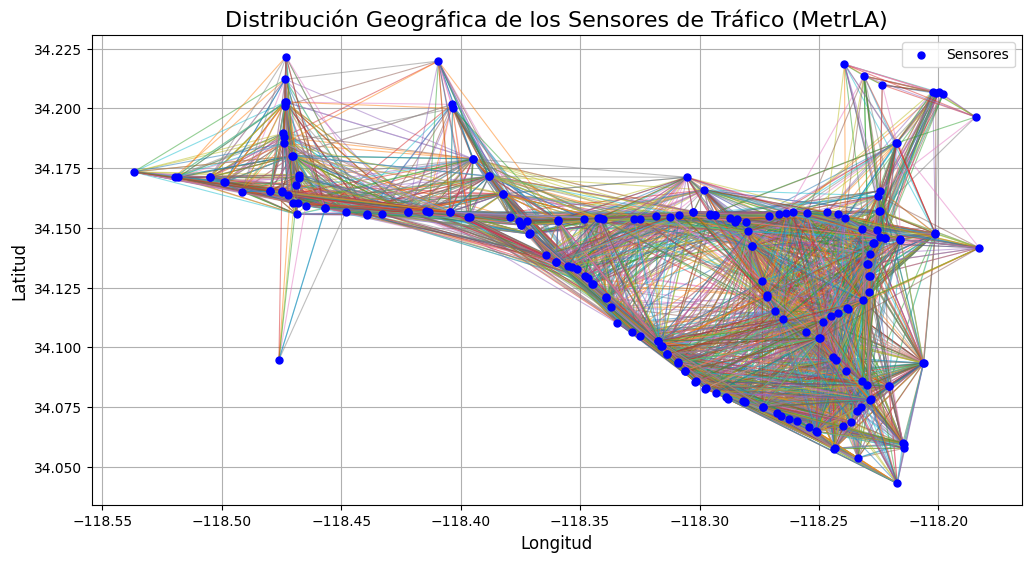

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Paso 1: Cargar los datos de las ubicaciones ---
try:
    # Cargamos las coordenadas geográficas de los sensores desde un archivo CSV
    locations_df = pd.read_csv('./data/locations.csv')
    x_coords = locations_df['longitude'].values
    y_coords = locations_df['latitude'].values

    # --- Paso 2: Obtener la matriz de conexiones (adyacencia) ---
    # Esto usa la variable 'dataset' que cargamos en los primeros pasos.
    adjacency_matrix = np.where(dataset.dist == np.inf, 0, 1)
    # Nos aseguramos de que no haya auto-conexiones (diagonal en 0)
    np.fill_diagonal(adjacency_matrix, 0)
    
    # --- Paso 3: Dibujar el gráfico geográfico ---
    print("Generando el mapa geográfico de los sensores...")
    plt.figure(figsize=(12, 12))

    # Dibujar las conexiones entre los nodos
    for i in range(adjacency_matrix.shape[0]):
        for j in range(i + 1, adjacency_matrix.shape[1]):
            # Si hay un 1 en la matriz de adyacencia, significa que los nodos i y j son vecinos
            if adjacency_matrix[i, j] == 1:
                # Dibujamos una línea entre sus coordenadas geográficas
                plt.plot([x_coords[i], x_coords[j]], [y_coords[i], y_coords[j]], 
                         alpha=0.5, linewidth=0.8)

    # Dibujar los nodos (sensores) encima de las líneas
    plt.scatter(x_coords, y_coords, s=25, c='blue', zorder=2, label='Sensores')

    # Añadir etiquetas y título
    plt.title("Distribución Geográfica de los Sensores de Tráfico (MetrLA)", fontsize=16)
    plt.xlabel("Longitud", fontsize=12)
    plt.ylabel("Latitud", fontsize=12)
    plt.legend()
    plt.grid(True)

    # Esto asegura que el mapa no se vea deformado (la escala de los ejes es la misma)
    plt.gca().set_aspect('equal', adjustable='box')

    # Mostramos el gráfico final
    plt.show()

except FileNotFoundError:
    print("Error: El archivo 'locations.csv' no fue encontrado. Por favor, asegúrate de subirlo.")
except NameError:
    print("\nError: La variable 'dataset' no está definida.")
    print("Por favor, ejecuta de nuevo la celda que carga el dataset MetrLA.")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

Ahora veamos qué aspecto tienen las lecturas de velocidad.

In [9]:
dataset.dataframe()  

nodes,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
channels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-03-01 00:00:00,64.38,67.62,67.12,61.50,66.88,68.75,65.12,67.12,59.62,62.75,...,45.62,65.50,64.50,66.43,66.88,59.38,69.00,59.25,69.00,61.88
2012-03-01 00:05:00,62.67,68.56,65.44,62.44,64.44,68.11,65.00,65.00,57.44,63.33,...,50.67,69.88,66.67,58.56,62.00,61.11,64.44,55.89,68.44,62.88
2012-03-01 00:10:00,64.00,63.75,60.00,59.00,66.50,66.25,64.50,64.25,63.88,65.38,...,44.12,69.00,56.50,59.25,68.12,62.50,65.62,61.38,69.86,62.00
2012-03-01 00:15:00,64.00,63.75,60.00,59.00,66.50,66.25,64.50,64.25,63.88,65.38,...,44.12,69.00,56.50,59.25,68.12,62.50,65.62,61.38,69.86,62.00
2012-03-01 00:20:00,64.00,63.75,60.00,59.00,66.50,66.25,64.50,64.25,63.88,65.38,...,44.12,69.00,56.50,59.25,68.12,62.50,65.62,61.38,69.86,62.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-27 23:35:00,65.00,65.89,68.56,61.67,32.83,54.56,62.44,63.33,59.22,65.33,...,52.89,69.00,65.11,55.67,66.33,62.44,66.78,64.89,69.67,62.33
2012-06-27 23:40:00,61.38,65.62,66.50,62.75,32.83,50.50,62.00,67.00,65.25,67.12,...,54.00,69.25,60.12,60.50,67.25,59.38,66.00,61.25,69.00,62.00
2012-06-27 23:45:00,67.00,59.67,69.56,61.00,32.83,44.78,64.22,63.78,59.78,57.67,...,51.33,67.89,64.33,57.00,66.00,62.67,68.67,63.33,67.44,61.22


Para entenderlo mucho mejor, veamos la grafica de las velocidades de algunos sensores

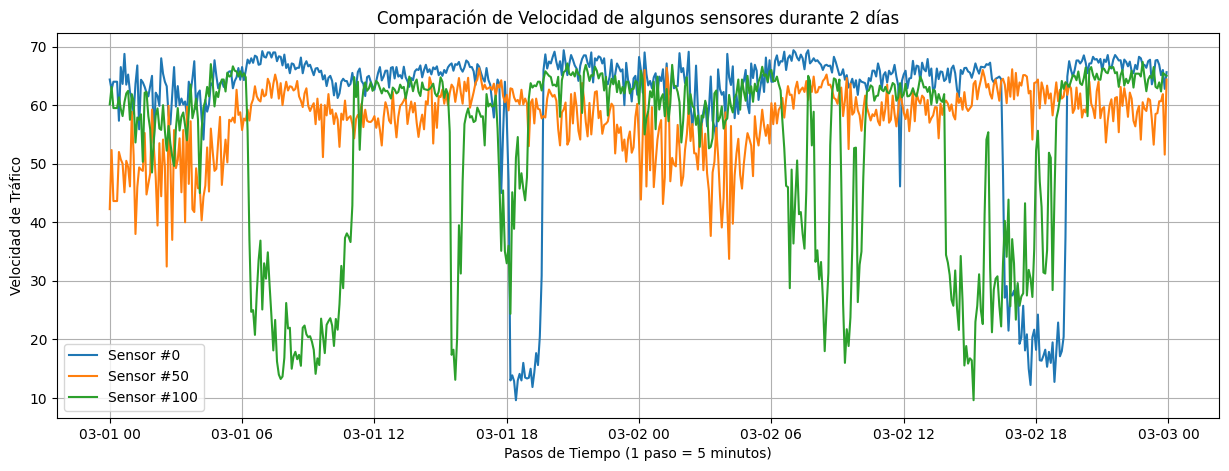

In [10]:
import matplotlib.pyplot as plt

# Seleccionamos algunos sensores para graficar
sensor_indices = [0, 50, 100]
days_to_plot = 2
points_per_day = 24 * (60 // 5)
time_steps_to_plot = points_per_day * days_to_plot
time_axis = dataset.target.index[:time_steps_to_plot]

# --- Graficar ---
plt.figure(figsize=(15, 5))
for idx in sensor_indices:
    speed_data = dataset.target.values[:time_steps_to_plot, idx]
    plt.plot(time_axis, speed_data, label=f'Sensor #{idx}')

plt.title(f"Comparación de Velocidad de algunos sensores durante {days_to_plot} días")
plt.xlabel("Pasos de Tiempo (1 paso = 5 minutos)")
plt.ylabel("Velocidad de Tráfico")
plt.legend()
plt.grid(True)
plt.show()

### Conectando sensores

Además de las series temporales, para usar correctamente los modelos basados en grafos, necesitamos __conectar__ los nodos de alguna manera.

Con el método [`dataset.get_similarity()`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets_prototypes.html#tsl.datasets.prototypes.Dataset.get_similarity) podemos recuperar las similitudes de los nodos calculadas con diferentes métodos. Los métodos de similitud disponibles para un conjunto de datos se pueden encontrar en `dataset.similarity_options`, mientras que el predeterminado está en `dataset.similarity_score`.

In [11]:
print(f"Default similarity: {dataset.similarity_score}")
print(f"Available similarity options: {dataset.similarity_options}")
print("==========================================")

sim = dataset.get_similarity("distance")  # or dataset.compute_similarity()

print("Similarity matrix W:")
print_matrix(sim)

Default similarity: distance
Available similarity options: {'distance'}
Similarity matrix W:


,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.39,0.00,0.00,0.00,0.00,0.39,0.00,0.00,...,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00
2,0.00,0.72,1.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,1.00,0.63,0.00,0.01,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.63,1.00,0.05,0.14,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.08,0.00,0.00,0.00
203,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
204,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,...,0.13,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
205,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


Con este método, calculamos el peso $w_t^{i,j}$ de la arista que conecta el nodo $i$-ésimo y el $j$-ésimo como<br>
$$
w^{i,j} = \left\{\begin{array}{cl}
     \exp \left(-\frac{\operatorname{dist}\left(i, j\right)^{2}}{\gamma}\right) & \operatorname{dist}\left(i, j\right) \leq \delta  \\
     0 & \text{en otro caso}
\end{array}\right. ,
$$<br>
donde $\operatorname{dist}\left(i, j\right)$ es la distancia entre el nodo $i$-ésimo y el $j$-ésimo, $\gamma$ controla el ancho del kernel y $\delta$ es un umbral. Nótese que en este caso la matriz de similitud no es simétrica, ya que la matriz de distancias preprocesada original tampoco lo es.

Hasta aquí todo bien, ahora podemos construir una matriz de adyacencia a partir de la similitud calculada.

El método [`dataset.get_connectivity()`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets_prototypes.html#tsl.datasets.prototypes.Dataset.get_connectivity) – que llama a `dataset.get_similarity()` internamente – proporciona opciones útiles de preprocesamiento y, finalmente, devuelve una matriz de adyacencia posiblemente dispersa y posiblemente ponderada.

In [12]:
connectivity = dataset.get_connectivity(threshold=0.1,
                                        include_self=False,
                                        normalize_axis=1,
                                        layout="edge_index")
print(connectivity)

(array([[  0,   0,   0, ..., 206, 206, 206],
       [ 13,  36,  58, ..., 157, 162, 198]]), array([0.08 , 0.163, 0.031, ..., 0.045, 0.031, 0.115], dtype=float32))


Veamos qué sucede con esta llamada a la función:

1. calcula la matriz de similitud como antes;
2. establece en 0 los valores por **debajo** de 0.1 (`threshold=0.1`);
3. **elimina** los auto-bucles (`include_self=False`);
4. **normaliza** los pesos de las aristas por el **grado de entrada** de los nodos (`normalize_axis=1`);
5. solicita el **formato disperso COO** de PyG (`layout="edge_index"`)

La matriz de conectividad con el formato `edge_index` se proporciona en formato COO, adoptando la convención y notación utilizada en PyTorch Geometric. La conectividad devuelta es una tupla (`edge_index`, `edge_weight`), donde `edge_index` enumera todas las aristas como pares de nodos origen-destino (dimensiones `[2, E]`) y `edge_weight` (dimensión `[E]`) almacena los pesos correspondientes.

In [13]:
edge_index, edge_weight = connectivity

print(f'edge_index {edge_index.shape}:\n', edge_index)
print(f'edge_weight {edge_weight.shape}:\n', edge_weight)

edge_index (2, 1515):
 [[  0   0   0 ... 206 206 206]
 [ 13  36  58 ... 157 162 198]]
edge_weight (1515,):
 [0.08  0.163 0.031 ... 0.045 0.031 0.115]


El formato COO representa el grafo usando principalmente dos tensores (o listas):

`edge_index`: Este es el corazón del formato COO. Es una lista de coordenadas que te dice qué nodos están conectados. Tiene dos filas:
- Fila 0: El nodo de origen de la conexión.
- Fila 1: El nodo de destino de la conexión.

`edge_weight`: Esta es una lista que contiene el "peso" o las características de cada conexión listada en edge_index.

Veamos ahora de manera grafica como estan interconectados estos nodos:

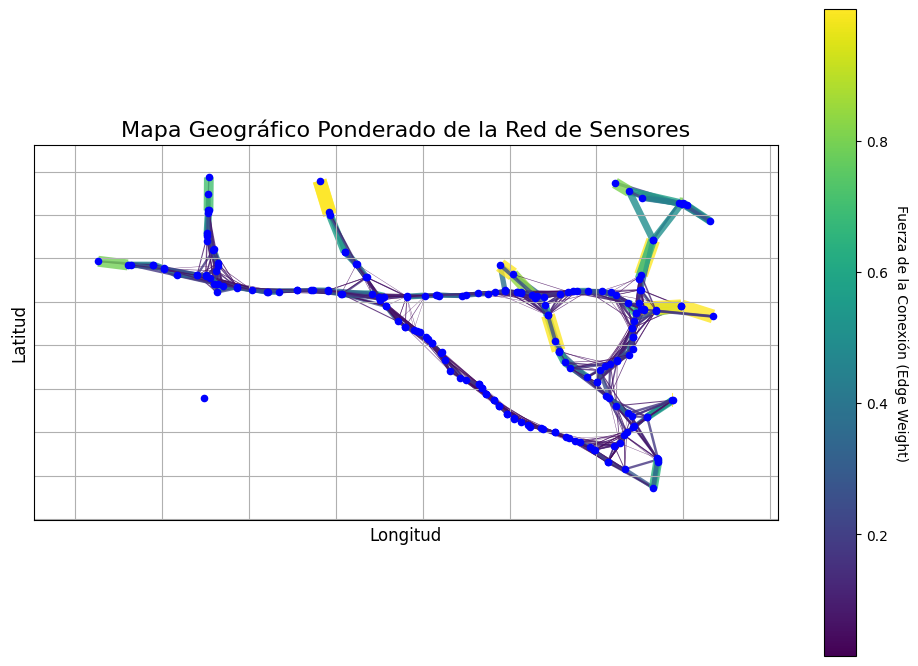

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Creamos el diccionario 'pos' que networkx necesita: {node_id: (longitude, latitude)}
pos = {i: (lon, lat) for i, lon, lat in zip(locations_df.index, locations_df['longitude'], locations_df['latitude'])}

num_nodes = locations_df.shape[0]

# --- Paso 3: Construir el objeto de grafo en NetworkX ---
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
for i in range(edge_index.shape[1]):
    source = edge_index[0, i]
    target = edge_index[1, i]
    weight = edge_weight[i]
    G.add_edge(source, target, weight=weight)

# --- Paso 4: Dibujar el grafo sobre el mapa geográfico ---
fig, ax = plt.subplots(figsize=(12, 12))

# Extraemos los pesos para darles color y grosor a las aristas
weights = np.array([G[u][v]['weight'] for u, v in G.edges()])

# Dibujamos los nodos (sensores) en sus coordenadas reales
nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=20, ax=ax)

# Dibujamos las aristas usando los pesos para el color y el grosor
edges = nx.draw_networkx_edges(
    G,
    pos,  # <-- ¡Aquí está la magia! Usamos las coordenadas geográficas
    edge_color=weights,
    width=weights * 10,  # Multiplicamos para que el grosor sea más notable
    edge_cmap=plt.cm.viridis,
    alpha=0.8,
    ax=ax
)

# --- Paso 5: Añadir la barra de color y los detalles finales ---
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=weights.min(), vmax=weights.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Fuerza de la Conexión (Edge Weight)', rotation=270, labelpad=15)

ax.set_title("Mapa Geográfico Ponderado de la Red de Sensores", fontsize=16)
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)
ax.grid(True)
ax.set_aspect('equal', adjustable='box') # Esencial para que el mapa no se deforme

plt.show()

## Creando un conjunto de datos listo para PyTorch
<hr>

En esta sección, veremos cómo obtener **señales de grafos espaciotemporales** que luego se entregan como entrada a una red neuronal (por ejemplo, una STGNN) a partir de un conjunto de datos de este tipo.

La primera clase que nos ayuda es [`tsl.data.SpatioTemporalDataset`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_pytorch_datasets.html#tsl.data.SpatioTemporalDataset). Esta clase es una subclase de [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) y se encarga de mapear un conjunto de datos tabular representado en tu formato preferido (por ejemplo, un array de numpy, un dataframe de pandas o el mencionado [`tsl.datasets.Dataset`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/datasets_prototypes.html#tsl.datasets.prototypes.Dataset)) a una implementación lista para PyTorch.

En particular, un objeto `SpatioTemporalDataset` se puede usar para lograr lo siguiente:
* Realizar operaciones de **manipulación de datos** necesarias para alimentar los datos a un módulo de PyTorch (p. ej., convertir datos a `torch.tensor`, manejar `shapes` posiblemente diferentes, sincronizar datos temporales).
* Crear **muestras `(input, target)`** para el aprendizaje supervisado siguiendo el enfoque de [**sliding window**](https://torch-spatiotemporal.readthedocs.io/en/latest/usage/spatiotemporal_dataset.html#sliding-window).
* Definir cómo se deben **organizar** los datos en una **señal de grafo espaciotemporal** (p. ej., cuáles son las entradas y los objetivos, cómo los atributos de los nodos y las variables covariables se mapean en un único grafo).
* **Preprocesar** los datos antes de crear una **señal de grafo espaciotemporal** aplicando operaciones de [**transformacion**](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/transforms.html) o [**escalamiento**](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_preprocessing.html).

Veamos cómo pasar de un `Dataset` a un `SpatioTemporalDataset`.

In [15]:
from tsl.data import SpatioTemporalDataset

torch_dataset = SpatioTemporalDataset(target=dataset.dataframe(),
                                      connectivity=connectivity,
                                      mask=dataset.mask,
                                      horizon=12,
                                      window=12,
                                      stride=1)
print(torch_dataset)

SpatioTemporalDataset(n_samples=34249, n_nodes=207, n_channels=1)


La línea `torch_dataset = SpatioTemporalDataset(...)` crea un objeto que contiene miles de muestras de entrenamiento. Lo hace utilizando una técnica llamada ventana deslizante (sliding window), que se ilustra como ejemplo en el diagrama que encontramos debajo. 

<h5 style="color: red;">La imagen es referencial, no es una representacion fiel de nuestros datos, es solamente para entender la tecnica de sliding window que utilizaremos</h5>

Veamos los parámetros clave y cómo se relacionan con la imagen:

`target=dataset.dataframe()`: Aquí le pasas los datos brutos de las series temporales de los 207 sensores.

`connectivity=connectivity`: Le entregas la estructura del grafo (el `edge_index` y `edge_weight`). Esta es la parte espacial (Spatio).

`mask=dataset.mask`: Es un mapa de datos faltantes. Le dice al modelo qué valores en tu serie de tiempo son reales y cuáles deben ser ignorados porque no son válidos (por ejemplo, un sensor se apagó o hubo un error de lectura).

`window=12`: Es la ventana de observación (el cuadro azul en el diagrama). Para cada ejemplo de entrenamiento, el modelo mirará los 12 datos más recientes del pasado. Esta es la parte temporal (Temporal).

`horizon=12`: Es el horizonte de predicción (el cuadro verde). Basándose en la window de 12 pasos, el modelo intentará predecir los siguientes 12 pasos en el futuro.

`stride=1`: Es el paso de deslizamiento. Indica que para crear el siguiente ejemplo de entrenamiento, la ventana se desliza solo un paso hacia el futuro. Esto permite generar muchos más ejemplos a partir de los mismos datos.

<hr>

El resultado que se imprime, `SpatioTemporalDataset(n_samples=34249, n_nodes=207, n_channels=1)`, indica lo que se ha creado:

`n_samples=34249`: Al aplicar esta ventana deslizante sobre toda tu serie temporal, se han generado 34,249 muestras de entrenamiento individuales. Cada muestra es un par (ventana de 12 pasos, horizonte de 12 pasos).

`n_nodes=207`: Confirma que cada una de esas muestras contiene datos de tus 207 sensores.

`n_channels=1`: Indica que cada sensor mide una sola variable (en nuestro caso la velocidad) en cada instante de tiempo.

Como puedes ver, el número de muestras no es el mismo que el número de pasos que tenemos en el conjunto de datos. De hecho, dividimos la serie temporal histórica con una **sliding window** de **12 pasos de tiempo** para la **ventana de observación hacia atrás** (`window=12`), con un **horizonte** correspondiente de **12 pasos de tiempo** (`horizon=12`). Por lo tanto, una única muestra abarca un total de 24 pasos de tiempo. El parámetro `stride` establece cuántos pasos de tiempo transcurren entre dos muestras consecutivas. La siguiente imagen ayuda a visualizar cómo estos (y otros) parámetros afectan al particionamiento de la serie temporal original en muestras.

<p align="center">
  <img src="https://torch-spatiotemporal.readthedocs.io/en/latest/_images/sliding_window.svg" width="500em">
</p>

## Señales de grafos espaciotemporales en tsl

Ahora tenemos un conjunto de datos basado en PyTorch que contiene una colección de señales de grafos espaciotemporales. Podemos obtener muestras de la misma manera que obtenemos elementos de una lista de Python. Veamos en detalle el diseño de una muestra:

In [16]:
sample = torch_dataset[0]
print(sample)

Data(
  input=(x=[t=12, n=207, f=1], edge_index=[2, e=1515], edge_weight=[e=1515]),
  target=(y=[t=12, n=207, f=1]),
  has_mask=True
)


Una muestra es de tipo [`tsl.data.Data`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_objects.html#tsl.data.Data), la clase base para representar señales de grafos espaciotemporales en tsl. Esta clase extiende [`torch_geometric.data.Data`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data), conservando todas sus funcionalidades y añadiendo utilidades para el procesamiento de datos espaciotemporales. Las principales API de `Data` incluyen:

* **`Data.input`**: vista de los tensores almacenados en `Data` que están destinados a servir como entrada para el modelo. En el caso más simple de una única matriz de atributos de nodo, podríamos tener simplemente `Data.input.x`.
* **`Data.target`**: vista de los tensores almacenados en `Data` utilizados como etiquetas para entrenar el modelo. En el caso común de una única etiqueta, podríamos tener simplemente `Data.input.y`.
* **`Data.edge_index`**: conectividad del grafo en formato COO (es decir, como pares de nodos).
* **`Data.edge_weight`**: pesos de la conectividad del grafo, si los hay.
* **`Data.mask`**: máscara binaria que indica los datos en `Data.target.y` que se utilizarán como verdad fundamental (ground-truth) para la pérdida (el valor predeterminado es `None`).

Ninguno de estos atributos es obligatorio y se pueden añadir atributos personalizados sin problemas.

Veamos con más detalle cómo se compone cada uno de estos atributos.

#### Input y Target

`Data.input` y `Data.target` proporcionan una **vista** sobre el almacenamiento único (compartido) en `Data`, de tal manera que la misma clave en `Data.input` y `Data.target` no puede hacer referencia a objetos diferentes.

In [17]:
sample.input.to_dict()

{'x': tensor([[[64.375],
          [67.625],
          ...,
          [69.000],
          [61.875]],
 
         [[62.667],
          [68.556],
          ...,
          [68.444],
          [62.875]],
 
         ...,
 
         [[65.222],
          [63.667],
          ...,
          [67.222],
          [60.000]],
 
         [[62.250],
          [67.750],
          ...,
          [66.500],
          [59.429]]]),
 'edge_index': tensor([[  0,   0,  ..., 206, 206],
         [ 13,  36,  ..., 162, 198]]),
 'edge_weight': tensor([0.080, 0.163,  ..., 0.031, 0.115])}

In [18]:
sample.target.to_dict()

{'y': tensor([[[61.125],
          [67.000],
          ...,
          [70.000],
          [63.500]],
 
         [[58.556],
          [62.667],
          ...,
          [66.222],
          [62.333]],
 
         ...,
 
         [[63.222],
          [64.111],
          ...,
          [67.333],
          [63.000]],
 
         [[65.000],
          [63.000],
          ...,
          [64.125],
          [60.750]]])}

Veamos algunos datos de nuestra muestra de forma grafica

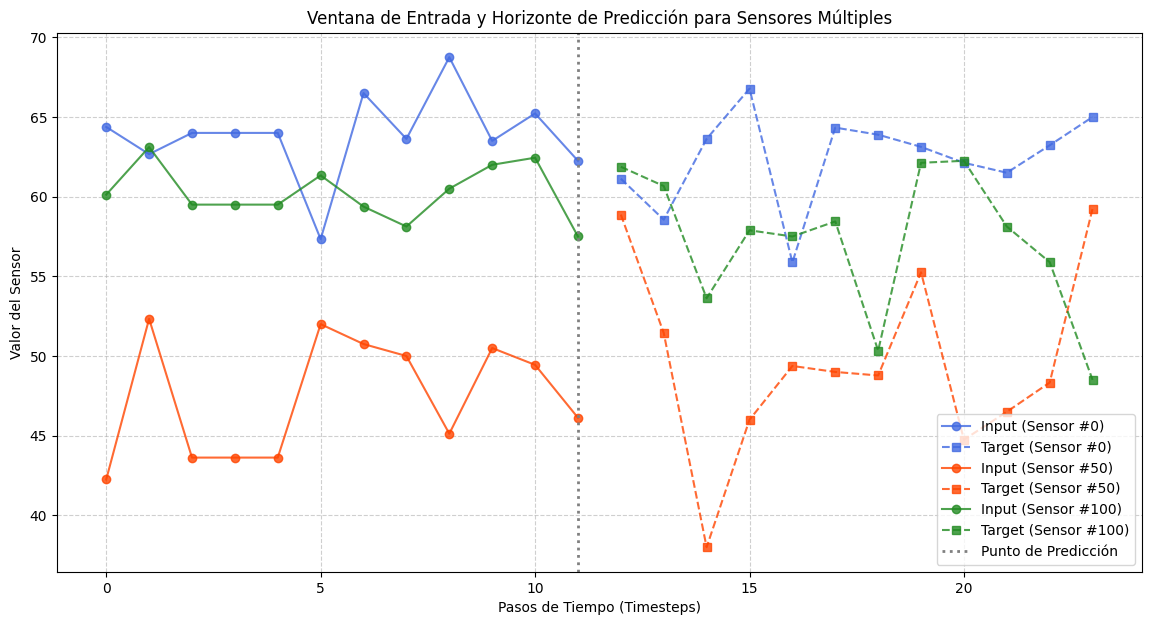

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Lista de los sensores que quieres visualizar
sensors_to_plot = [0, 50, 100]
colors = ['royalblue', 'orangered', 'forestgreen'] # Colores para cada sensor

# --- Creación del Gráfico ---
plt.figure(figsize=(14, 7))
plt.grid(True, linestyle='--', alpha=0.6)

# Bucle para graficar cada sensor de la lista
for i, sensor_id in enumerate(sensors_to_plot):
    # Extrae los datos de entrada ('x') y de salida ('y') para el sensor actual
    input_data = sample.input['x'][:, sensor_id].squeeze().numpy()
    target_data = sample.target['y'][:, sensor_id].squeeze().numpy()

    # Crea los ejes de tiempo para el gráfico
    input_timesteps = np.arange(len(input_data))
    target_timesteps = np.arange(len(input_data), len(input_data) + len(target_data))

    # Grafica la serie de entrada para el sensor actual
    plt.plot(input_timesteps, input_data, 'o-', label=f'Input (Sensor #{sensor_id})', color=colors[i], alpha=0.8)

    # Grafica la serie objetivo para el sensor actual
    plt.plot(target_timesteps, target_data, 's--', label=f'Target (Sensor #{sensor_id})', color=colors[i], alpha=0.8)

# Añade una línea vertical para separar claramente el input del target
plt.axvline(x=input_timesteps[-1], color='gray', linestyle=':', linewidth=2, label='Punto de Predicción')

plt.title(f'Ventana de Entrada y Horizonte de Predicción para Sensores Múltiples')
plt.xlabel('Pasos de Tiempo (Timesteps)')
plt.ylabel('Valor del Sensor')
plt.legend()
plt.show()

## Preparando el conjunto de datos para el entrenamiento
<hr>

Generalmente, antes de ejecutar un experimento, hay dos pasos de preprocesamiento bastante comunes:

* **dividir** el conjunto de datos en conjuntos de **entrenamiento/validación/prueba**;
* **preprocesamiento de datos** (escalar/normalizar datos, eliminar tendencias).

En tsl, estas operaciones son gestionadas por el [`tsl.data.SpatioTemporalDataModule`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_datamodule.html#tsl.data.datamodule.SpatioTemporalDataModule), que se basa en el [`LightningDataModule`](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.core.LightningDataModule.html#pytorch_lightning.core.LightningDataModule) de [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/). Un `DataModule` nos permite estandarizar y hacer consistentes las divisiones de entrenamiento, validación y prueba, la preparación de datos y las transformaciones en diferentes entornos y experimentos.

Veamos un ejemplo

In [20]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
from tsl.data.preprocessing import StandardScaler

# Normalize data using mean and std computed over time and node dimensions
scalers = {'target': StandardScaler(axis=(0, 1))}

# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=64,
)

dm.setup()
print(dm)

{Train dataloader: None}
{Validation dataloader: None}
{Test dataloader: None}
{Predict dataloader: None}


Durante el `setup`, el datamodule realiza las siguientes operaciones:

1. Lleva a cabo la división del conjunto de datos en conjuntos de entrenamiento/validación/prueba de acuerdo con el proporcionado [`Splitter`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/data_datamodule.html#tsl.data.datamodule.splitters.Splitter).
2. Ajusta todos los `Scalers` a los datos de entrenamiento en `torch_dataset` correspondientes a la clave de los escaladores.

`SpatioTemporalDataModule`: Es un organizador de alto nivel que prepara el dataset para el entrenamiento. Automatiza dos pasos críticos: el escalado de los datos y su división en conjuntos de entrenamiento, validación y prueba.

`scalers`:
- `StandardScaler` normaliza los datos para que todos los sensores operen en una escala comparable.
- Transforma los datos para que tengan una media de 0 y una desviación estándar de 1 (Z-score).
- Evita que el modelo le dé más importancia a sensores con valores numéricos más altos, asegurando que el aprendizaje se base en los patrones y no en la magnitud. Es como hacer que todos los sensores "hablen el mismo idioma numérico".

`splitter`:
- `TemporalSplitter` divide el dataset cronológicamente para una evaluación justa del modelo.
- Separa los datos en tres bloques secuenciales:
    - Entrenamiento (Train): Los datos más antiguos, para que el modelo aprenda.
    - Validación (Validation): Datos intermedios, para ajustar el modelo durante el entrenamiento.
    - Prueba (Test): Los datos más recientes, para evaluar el rendimiento final del modelo en información completamente nueva.

`batch_size` (Tamaño del Lote):
- Define cuántas muestras de datos (pares de ventana/horizonte) se procesan simultáneamente en cada paso del entrenamiento.
- `batch_size=64`: Significa que el modelo mirará 64 ejemplos a la vez para actualizar sus parámetros.
- Es un equilibrio entre velocidad y memoria. Lotes más grandes pueden acelerar el entrenamiento pero consumen más memoria RAM/VRAM. Lotes pequeños son más lentos pero más ligeros. Es como comerse un pastel en rebanadas manejables en lugar de todo de un solo bocado.

<hr>

# **Construcción de Redes Neuronales de Grafos Espaciotemporales**

<hr>

## Diseñando una STGNN personalizada
<hr>

Manos a la obra y creemos nuestra primera STGNN simple! Seguiremos el paradigma **Tiempo-luego-Espacio (Time-then-Space)**.Usamos una GRU compartida entre los nodos para procesar la dimensión temporal. Esto nos dará como salida un único vector de características para cada nodo, que luego se propaga a través del grafo subyacente utilizando una GNN Convolucional de Difusión. Antes y después, añadimos transformaciones lineales para codificar las características de entrada y decodificar las representaciones aprendidas. También hacemos uso de **incrustaciones de nodos (node embeddings)** (parámetros libres aprendidos individualmente para cada nodo) para hacer de nuestra STGNN un **modelo global-local** ([Cini et al., 2023](https://arxiv.org/abs/2302.04071)).

Todas las capas que necesitamos se proporcionan dentro de `tsl.nn`. Usamos:
* [`RNN`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn_blocks.html#tsl.nn.blocks.encoders.RNN) de `tsl.nn.blocks.encoders` para la GRU;
* [`DiffConv`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/nn_layers.html#tsl.nn.layers.graph_convs.DiffConv) de `tsl.nn.layers.graph_convs` para la convolución de difusión;
* `StaticGraphEmbedding` de `tsl.nn.base` para las incrustaciones de nodos.

In [21]:
import torch.nn as nn

from tsl.nn.blocks import RNN, MLPDecoder
from tsl.nn.layers import NodeEmbedding, DiffConv


class TimeThenSpaceModel(nn.Module):
    def __init__(self, input_size: int, n_nodes: int, horizon: int,
                 emb_size: int = 16,
                 hidden_size: int = 32,
                 rnn_layers: int = 1,
                 gnn_kernel: int = 2):
        super(TimeThenSpaceModel, self).__init__()

        self.node_embeddings = NodeEmbedding(n_nodes, emb_size)

        # Encoder
        self.encoder = nn.Linear(input_size + emb_size, hidden_size)

        # STMP
        self.time_nn = RNN(input_size=hidden_size,
                           hidden_size=hidden_size,
                           n_layers=rnn_layers,
                           cell='gru',
                           return_only_last_state=True)

        self.space_nn = DiffConv(in_channels=hidden_size,
                                 out_channels=hidden_size,
                                 k=gnn_kernel,
                                 root_weight=True)
        # Decoder
        self.decoder = MLPDecoder(input_size=hidden_size + emb_size,
                                  hidden_size=2 * hidden_size,
                                  output_size=input_size,
                                  horizon=horizon,
                                  n_layers=1)

    def forward(self, x, edge_index, edge_weight):
        # x: [batch time nodes features]
        b, t, n, f = x.size()
        # Concatenate node embeddings to input
        emb = self.node_embeddings(expand=(b, t, -1, -1))
        x_emb = torch.cat([x, emb], dim=-1)
        # Encoder
        x_enc = self.encoder(x_emb)  # linear proj: x_enc = [x||emb]Θ + b
        # STMP
        h = self.time_nn(x_enc)  # temporal processing: x=[b t n f] -> h=[b n f]
        z = self.space_nn(h, edge_index, edge_weight)  # spatial processing
        # Decoder
        emb = self.node_embeddings(expand=(b, -1, -1))
        z_emb = torch.cat([z, emb], dim=-1)  # concatenate node embeddings to z
        x_out = self.decoder(z_emb)  # linear proj: z=[b n f] -> x_out=[b n t⋅f]
        return x_out

Este código define la arquitectura de la red neuronal, el "cerebro" que aprenderá a predecir el futuro. El nombre del modelo, `TimeThenSpaceModel`, revela su estrategia: primero analiza los patrones a lo largo del tiempo para cada sensor de forma independiente, y luego combina esa información a través del espacio (el grafo de sensores).

Aquí tienes un desglose de sus componentes y cómo funcionan juntos.

### Arquitectura del Modelo (__init__)
Esta sección es como la lista de "ingredientes" o componentes del modelo. Cada uno es una capa especializada con una tarea específica.

- `self.node_embeddings` (La Cédula de Identidad del Sensor): Esta capa crea un vector único y aprendible para cada uno de los 207 sensores. Esto le permite al modelo distinguir entre ellos y aprender características específicas de cada ubicación (por ejemplo, que un sensor en una autopista se comporta diferente a uno en una calle residencial).
- `self.encoder` (La Capa de Preparación) Fija: Es una capa lineal simple que toma los datos de entrada junto con la "cédula de identidad" del sensor y los proyecta a un espacio de mayor dimensión (`hidden_size`). Su función es preparar y enriquecer la información para las capas más complejas que vienen después.
- `self.time_nn` (El Analista Temporal): Este es el primer componente principal. Utiliza una red neuronal recurrente (específicamente una GRU) para analizar la secuencia de datos pasados (la ventana de 12 pasos) de cada sensor por separado. Su trabajo es "leer" la historia temporal y resumirla en un único vector de estado que captura los patrones temporales (tendencias, estacionalidad, etc.).
- `self.space_nn` (El Comunicador Espacial): Este es el segundo componente principal. Es una Red Neuronal de Grafos (GNN). Toma los resúmenes temporales de todos los sensores y permite que "hablen" entre sí a través de las conexiones del grafo (`edge_index`). Un sensor ahora puede ajustar su estado basándose en la información de sus vecinos, aprendiendo así patrones espaciales (por ejemplo, "si el tráfico aumenta en el sensor A, es probable que aumente en el sensor B en el futuro cercano").
- `self.decoder` (El Pronosticador): Es la capa final. Toma la representación combinada de tiempo y espacio, la enriquece de nuevo con la "cédula" del sensor, y la utiliza para generar la predicción final para el horizonte de 12 pasos en el futuro.

## Flujo de Datos (forward)
Esta sección describe el "viaje" que realizan los datos a través del modelo en cada paso de entrenamiento.

- Enriquecer: Los datos de entrada x se combinan con los `node_embeddings`. Ahora cada dato no solo tiene su valor, sino también una etiqueta de qué sensor proviene.
- Codificar: La mezcla de datos y embeddings pasa por el `encoder` para prepararse.
- Procesar el TIEMPO: La `time_nn` (GRU) procesa la secuencia temporal de cada sensor y la colapsa en un único vector de resumen `h`. En este punto, el modelo ha entendido la historia de cada sensor.
- Procesar el ESPACIO: El vector `h` de cada sensor se pasa a la `space_nn` (GNN). Los sensores intercambian información con sus vecinos, produciendo un nuevo vector `z` que ahora contiene conocimiento espacio-temporal. En este punto, el modelo ha entendido cómo se influyen los sensores entre sí.
- Decodificar y Predecir: El vector final `z` se combina una última vez con los embeddings y se entrega al `decoder`, que genera la predicción final `x_out` con la forma `[batch, horizonte, nodos, features]`.

En resumen, el modelo implementa una estrategia muy intuitiva: primero entiende la historia individual de cada sensor y luego usa las conexiones del grafo para entender cómo el vecindario afecta a cada uno antes de hacer una predicción.

Podemos jugar con los hiperparámetros y crear una instancia de nuestro modelo.

In [22]:
emb_size = 16      #@param
hidden_size = 32  #@param
rnn_layers = 1     #@param
gnn_kernel = 2     #@param

input_size = torch_dataset.n_channels   # 1 channel
n_nodes = torch_dataset.n_nodes         # 207 nodes
horizon = torch_dataset.horizon         # 12 time steps

stgnn = TimeThenSpaceModel(input_size=input_size,
                           n_nodes=n_nodes,
                           horizon=horizon,
                           emb_size=emb_size,
                           hidden_size=hidden_size,
                           rnn_layers=rnn_layers,
                           gnn_kernel=gnn_kernel)
print(stgnn)
print_model_size(stgnn)

TimeThenSpaceModel(
  (node_embeddings): NodeEmbedding(n_nodes=207, embedding_size=16)
  (encoder): Linear(in_features=17, out_features=32, bias=True)
  (time_nn): RNN(
    (rnn): GRU(32, 32)
  )
  (space_nn): DiffConv(32, 32)
  (decoder): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=48, out_features=64, bias=True)
          (activation): ReLU()
          (dropout): Identity()
        )
      )
      (readout): Linear(in_features=64, out_features=12, bias=True)
    )
    (rearrange): Rearrange('b n (h f) -> b h n f', f=1, h=12)
  )
)
Number of model (TimeThenSpaceModel) parameters:     19292


Veamos ahora una única muestra de entrenamiento (la muestra 0) para un nodo específico (el nodo 0)

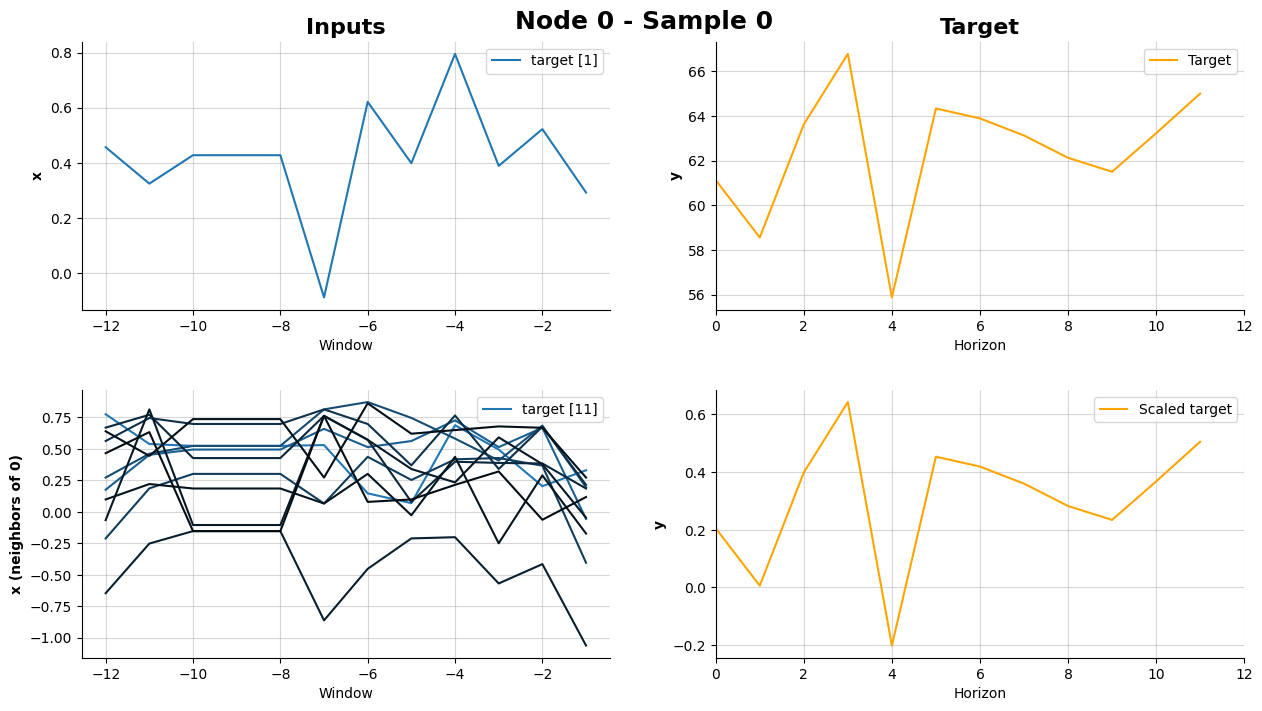

In [23]:
plot_inputs_and_target(torch_dataset, plot_neighbors=True)

**Gráfico 1 (Arriba Izquierda)**: Dibuja los datos de entrada del node_idx principal.

**Gráfico 2 (Arriba Derecha)**: Dibuja el target en su escala original, sin normalizar.

**Gráfico 3 (Abajo Izquierda)**: Si plot_neighbors es True, dibuja las series de tiempo de todos los vecinos del node_idx superpuestas. Utiliza la función auxiliar get_darker_shades para darles a las líneas de los vecinos colores similares pero distinguibles.

**Gráfico 4 (Abajo Derecha)**: Dibuja el scaled_target, la versión normalizada del objetivo que el modelo realmente intenta predecir.

Bien, hemos cargado los datos y construido un modelo, ¡así que vamos a entrenarlo!

## Configurando el entrenamiento
<hr>

Ahora estamos listos para entrenar nuestro modelo. Configuramos el procedimiento de entrenamiento como prefiramos; a continuación, usaremos el Trainer de PyTorch Lightning para reducir la carga del trabajo sucio. Recordemos que tsl está altamente integrado con librerías basadas en PyTorch ampliamente utilizadas, como PyTorch Lightning y PyTorch Geometric.

### El Predictor

En tsl, los motores de inferencia se implementan como un [`LightningModule`](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.core.LightningModule.html#pytorch_lightning.core.LightningModule). [`tsl.engines.Predictor`](https://torch-spatiotemporal.readthedocs.io/en/latest/modules/engines.html#tsl.engines.Predictor) es una clase base que se puede extender para construir enfoques de pronóstico más complejos. 

Estos módulos están diseñados para encapsular modelos profundos con el fin de facilitar las fases de entrenamiento e inferencia.

In [31]:
from tsl.metrics.torch import MaskedMAE, MaskedMAPE, MaskedMetric
from torchmetrics.functional.regression.r2 import _r2_score_update, _r2_score_compute
from tsl.engines import Predictor
import torch

loss_fn = MaskedMAE()

metrics = {'mae': MaskedMAE(),
           'mape': MaskedMAPE(),
           'mae_at_15': MaskedMAE(at=2),  # '2' indicates the third time step,
                                          # which correspond to 15 minutes ahead
           'mae_at_30': MaskedMAE(at=5),
           'mae_at_60': MaskedMAE(at=11),}

# setup predictor
predictor = Predictor(
    model=stgnn,                   # our initialized model
    optim_class=torch.optim.Adam,  # specify optimizer to be used...
    optim_kwargs={'lr': 0.001},    # ...and parameters for its initialization
    loss_fn=loss_fn,               # which loss function to be used
    metrics=metrics                # metrics to be logged during train/val/test
)
print(predictor)

Predictor(
  (loss_fn): MaskedMAE()
  (train_metrics): MetricCollection(
    (mae): MaskedMAE()
    (mae_at_15): MaskedMAE()
    (mae_at_30): MaskedMAE()
    (mae_at_60): MaskedMAE()
    (mape): MaskedMAPE(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (mae): MaskedMAE()
    (mae_at_15): MaskedMAE()
    (mae_at_30): MaskedMAE()
    (mae_at_60): MaskedMAE()
    (mape): MaskedMAPE(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (mae): MaskedMAE()
    (mae_at_15): MaskedMAE()
    (mae_at_30): MaskedMAE()
    (mae_at_60): MaskedMAE()
    (mape): MaskedMAPE(),
    prefix=test_
  )
  (model): TimeThenSpaceModel(
    (node_embeddings): NodeEmbedding(n_nodes=207, embedding_size=16)
    (encoder): Linear(in_features=17, out_features=32, bias=True)
    (time_nn): RNN(
      (rnn): GRU(32, 32)
    )
    (space_nn): DiffConv(32, 32)
    (decoder): MLPDecoder(
      (readout): MLP(
        (mlp): Sequential(
          (0): Dense(
            (affinity): Linear(in_fea

Ahora finalicemos los últimos detalles. Usamos [TensorBoard](https://www.tensorflow.org/tensorboard/) para registrar y visualizar métricas.

In [25]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir="logs", name="tsl_intro", version=0)

In [26]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_mae',
    mode='min',
)

trainer = pl.Trainer(max_epochs=100,
                     logger=logger,
                     # accelerator="gpu" if torch.cuda.is_available() else "cpu", # para windows
                     accelerator="mps", # para mac con chip m1/m2
                     devices=1,
                     limit_train_batches=1000,  # end an epoch after 1000 updates
                     callbacks=[checkpoint_callback])

trainer.fit(predictor, datamodule=dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/spatio_temporal/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:45: Attribute 'metrics' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['metrics'])`.
/opt/anaconda3/envs/spatio_temporal/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/rasec/Documents/github/SpaceTemporalGraphNeuralNetwork/logs exists and is not empty.

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | loss_fn       | MaskedMAE          | 0      | train
1 | train_metrics | MetricCollection   | 0      | train
2 | val_metrics   | MetricCollection   | 0      | train
3 | test_metrics  | MetricCollection   | 0      | train
4 | model         | TimeThenSpaceModel | 1

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Only args ['edge_index', 'x', 'edge_weight'] are forwarded to the model (TimeThenSpaceModel).


Epoch 99: 100%|██████████| 385/385 [00:30<00:00, 12.50it/s, v_num=0, val_mae=2.760, val_mae_at_15=2.400, val_mae_at_30=2.770, val_mae_at_60=3.280, val_mape=0.0736, val_r2=0.777, train_mae=3.050, train_mae_at_15=2.680, train_mae_at_30=3.070, train_mae_at_60=3.610, train_mape=0.0828, train_r2=0.774]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 385/385 [00:30<00:00, 12.50it/s, v_num=0, val_mae=2.760, val_mae_at_15=2.400, val_mae_at_30=2.770, val_mae_at_60=3.280, val_mape=0.0736, val_r2=0.777, train_mae=3.050, train_mae_at_15=2.680, train_mae_at_30=3.070, train_mae_at_60=3.610, train_mape=0.0828, train_r2=0.774]


## Pruebas

<hr>

Ahora veamos cómo se comporta el modelo entrenado con datos nuevos y no vistos.

In [28]:
# torch.serialization.add_safe_globals([
#     tsl.metrics.torch.metrics.MaskedMAE,
#     tsl.metrics.torch.metrics.MaskedMAPE,
#     tsl.metrics.torch.functional.mape,
#     torch.optim.Adam,
#     jit_distributed_available,
#     dim_zero_sum,
#     functools.partial,
#     torch.nn.functional.l1_loss,
#     slice
# ])

# Now, your original code will work correctly and safely
predictor.load_model(checkpoint_callback.best_model_path)
predictor.freeze()

trainer.test(predictor, datamodule=dm)

Predictor with already instantiated model is loading a state_dict from /Users/rasec/Documents/github/SpaceTemporalGraphNeuralNetwork/logs/epoch=79-step=30800.ckpt. Cannot  check if model hyperparameters are the same.


Testing DataLoader 0: 100%|██████████| 108/108 [00:15<00:00,  6.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            3.161543130874634
        test_mae            3.2769336700439453
     test_mae_at_15         2.8201684951782227
     test_mae_at_30          3.293227434158325
     test_mae_at_60         3.9590868949890137
        test_mape           0.0901750773191452
         test_r2            0.7658958435058594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mae': 3.2769336700439453,
  'test_mae_at_15': 2.8201684951782227,
  'test_mae_at_30': 3.293227434158325,
  'test_mae_at_60': 3.9590868949890137,
  'test_mape': 0.0901750773191452,
  'test_r2': 0.7658958435058594,
  'test_loss': 3.161543130874634}]

In [32]:
test_dataloader = dm.test_dataloader()
predictor.load_model(checkpoint_callback.best_model_path)
predictions_list = trainer.predict(model=predictor, dataloaders=test_dataloader)

Predictor with already instantiated model is loading a state_dict from /Users/rasec/Documents/github/SpaceTemporalGraphNeuralNetwork/logs/epoch=79-step=30800.ckpt. Cannot  check if model hyperparameters are the same.


Predicting DataLoader 0:   0%|          | 0/108 [00:00<?, ?it/s]

Only args ['edge_index', 'x', 'edge_weight'] are forwarded to the model (TimeThenSpaceModel).


Predicting DataLoader 0: 100%|██████████| 108/108 [00:03<00:00, 30.66it/s]



✅ ¡Predicción completada! Forma del tensor: torch.Size([6849, 12, 207, 1])


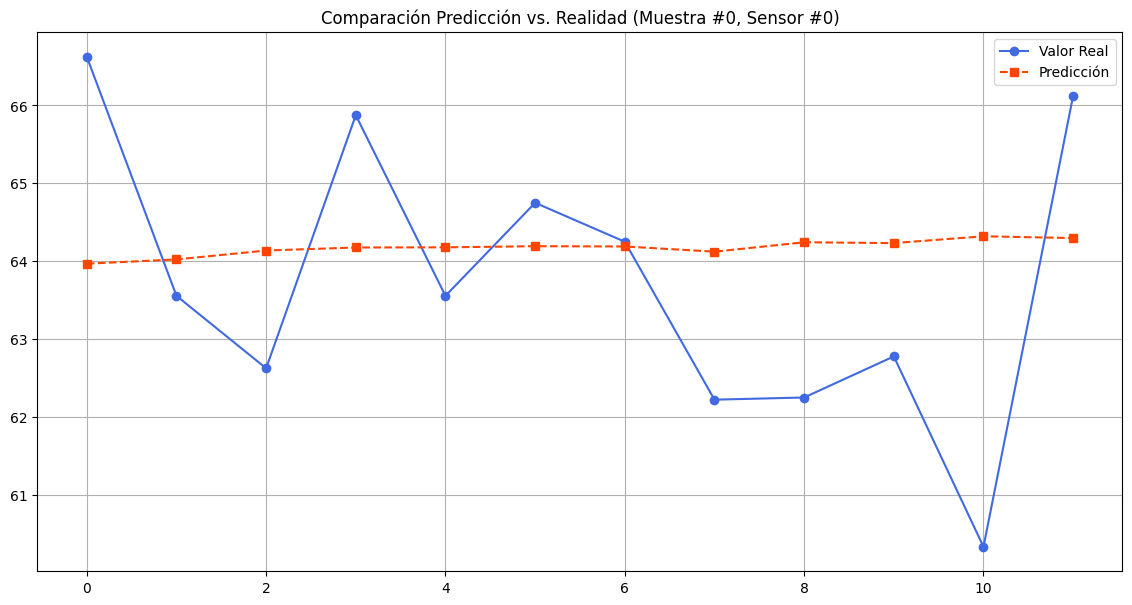

In [30]:
import torch
import matplotlib.pyplot as plt

# Unimos los lotes en un solo tensor
predictions = torch.cat([batch['y_hat'] for batch in predictions_list])

print(f"\n✅ ¡Predicción completada! Forma del tensor: {predictions.shape}")


# --- Paso 3: Visualizar un resultado ---
sample_idx = 0
node_idx = 0

prediction_sample = predictions[sample_idx, :, node_idx].squeeze().cpu().numpy()
ground_truth_sample = dm.testset[sample_idx].target['y'][:, node_idx].squeeze().cpu().numpy()

# ... (código del gráfico) ...
plt.figure(figsize=(14, 7))
plt.plot(ground_truth_sample, 'o-', label='Valor Real', color='royalblue')
plt.plot(prediction_sample, 's--', label='Predicción', color='orangered')
plt.title(f'Comparación Predicción vs. Realidad (Muestra #{sample_idx}, Sensor #{node_idx})')
plt.legend()
plt.grid(True)
plt.show()

Del grafico observamos que la prediccion no se asemeja demasiado a los valores reales.

Esta es una situación muy común en el modelado de series temporales y es un excelente indicador de lo que tu modelo ha aprendido (o no ha aprendido).

La predicción es tan plana porque el modelo ha descubierto que la estrategia más segura para minimizar el error promedio (usando una pérdida como MAE) es predecir el valor medio (o la media) de la serie temporal. No ha logrado capturar los patrones más complejos y volátiles (los picos y valles) de los datos reales.

En resumen, es un caso clásico de underfitting.

Analogía del Pronóstico del Tiempo 🌦️: Imagina a un meteorólogo novato que tiene mucho miedo a equivocarse. Si mira los datos históricos y ve que la temperatura promedio en tu ciudad es de 20°C, la forma más "segura" de no cometer un error garrafal es predecir "20°C" todos los días. Acertará en promedio, pero fallará en predecir los días de calor extremo o las olas de frío. Tu modelo está haciendo exactamente eso.

## Las Causas Más Probables
Capacidad del Modelo Insuficiente (Underfitting) 🧠: Esta es la causa más probable. El modelo (TimeThenSpaceModel) es demasiado simple para la complejidad de los datos de tráfico. Tiene muy pocas "neuronas" o "capas" para poder aprender las relaciones no lineales que causan los picos y valles. Con su capacidad actual, lo único que puede aprender es la tendencia central.

Entrenamiento Insuficiente 📉: Es posible que no hayas entrenado el modelo durante suficientes épocas. Puede que estuviera empezando a aprender los patrones más finos, pero el entrenamiento se detuvo antes de que pudiera converger a una solución más compleja.

Tasa de Aprendizaje (Learning Rate) no Óptima: Si la tasa de aprendizaje es demasiado baja, el modelo aprende tan lentamente que se queda atascado en la solución simple de predecir la media. Si es demasiado alta, sus ajustes son tan bruscos que nunca logra asentarse en los patrones complejos y vuelve a la media como punto de equilibrio.

Esta es una situación muy común en el modelado de series temporales y es un excelente indicador de lo que tu modelo ha aprendido (o no ha aprendido).

Tu predicción es tan plana porque el modelo ha descubierto que la estrategia más segura para minimizar el error promedio (usando una pérdida como MAE) es predecir el valor medio (o la media) de la serie temporal. No ha logrado capturar los patrones más complejos y volátiles (los picos y valles) de los datos reales.

En resumen, es un caso clásico de underfitting.

Analogía del Pronóstico del Tiempo 🌦️: Imagina a un meteorólogo novato que tiene mucho miedo a equivocarse. Si mira los datos históricos y ve que la temperatura promedio en tu ciudad es de 20°C, la forma más "segura" de no cometer un error garrafal es predecir "20°C" todos los días. Acertará en promedio, pero fallará en predecir los días de calor extremo o las olas de frío. Tu modelo está haciendo exactamente eso.

## Las Causas Más Probables
Capacidad del Modelo Insuficiente (Underfitting) 🧠: Esta es la causa más probable. El modelo (TimeThenSpaceModel) es demasiado simple para la complejidad de los datos de tráfico. Tiene muy pocas "neuronas" o "capas" para poder aprender las relaciones no lineales que causan los picos y valles. Con su capacidad actual, lo único que puede aprender es la tendencia central.

Entrenamiento Insuficiente 📉: Es posible que no hayas entrenado el modelo durante suficientes épocas. Puede que estuviera empezando a aprender los patrones más finos, pero el entrenamiento se detuvo antes de que pudiera converger a una solución más compleja.

Tasa de Aprendizaje (Learning Rate) no Óptima: Si la tasa de aprendizaje es demasiado baja, el modelo aprende tan lentamente que se queda atascado en la solución simple de predecir la media. Si es demasiado alta, sus ajustes son tan bruscos que nunca logra asentarse en los patrones complejos y vuelve a la media como punto de equilibrio.